In [1]:
import os
import numpy as np
from PIL import Image

def load_images_and_labels(folder_path):
    images = []
    labels = []
    
    for filename in os.listdir(folder_path):
        if filename.endswith(".png"):

            image_path = os.path.join(folder_path, filename)
            image = Image.open(image_path)
            image = image.convert("RGB")
            
            image_array = np.array(image) / 255.0
            images.append(image_array)
            
            if ("target" in filename) & ("nontarget" not in filename):
                labels.append(1)
            elif "nontarget" in filename:
                labels.append(-1)
            else:
                raise ValueError("Invalid filename format")
    
    return np.array(images), np.array(labels)

In [2]:
folder_path = "/Users/yohanabeysinghe/Mac/1. ENTC/FYP - Ear EEG/Datasets/ConvertedToImages"
X, Y = load_images_and_labels(folder_path)

print("Shape of X:", X.shape)
print("Shape of Y:", Y.shape) 

Shape of X: (314, 576, 2304, 3)
Shape of Y: (314,)


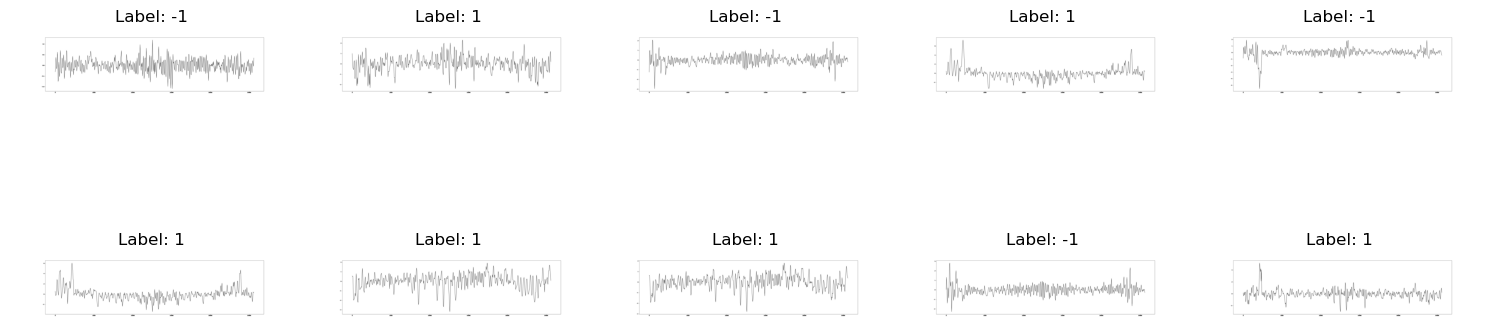

In [3]:
import matplotlib.pyplot as plt

num_samples = X.shape[0]
random_indices = np.random.choice(num_samples, size=10, replace=False)

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, idx in enumerate(random_indices):
    row = i // 5
    col = i % 5
    axes[row, col].imshow(X[idx])
    axes[row, col].set_title("Label: {}".format(Y[idx]))
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

In [4]:
print(Y)

[-1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1 -1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1 -1 -1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1 -1 -1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1  1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1  1  1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1 -1 -1 -1 -1 -1 -1 -1
 -1 -1]


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

num_samples, height, width, channels = X.shape
X_flat = X.reshape(num_samples, height * width * channels)

X_train, X_test, Y_train, Y_test = train_test_split(X_flat, Y, test_size=0.2, random_state=42)

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

rf_classifier.fit(X_train, Y_train)
Y_pred = rf_classifier.predict(X_test)

accuracy = accuracy_score(Y_test, Y_pred)
print("Accuracy:", accuracy)


Accuracy: 1.0


In [6]:
print(X_test[0].shape)
print(X_train[0].shape)

(3981312,)
(3981312,)


In [7]:
import skimage.segmentation
import skimage.io
import copy
import sklearn
from sklearn.linear_model import LinearRegression

In [8]:
Xi_ = Image.open("/Users/yohanabeysinghe/Mac/1. ENTC/FYP - Ear EEG/Datasets/ConvertedToImages/nontarget_s01_trial_00.png")
Xi = Xi_.convert("RGB")
Xi = Xi.resize((2304, 576))
Xi = np.array(Xi) #/ 255.0
Xi_flat = Xi.flatten().reshape(1, -1)
Xi_flat.shape

(1, 3981312)

In [9]:
type(Xi_)

PIL.PngImagePlugin.PngImageFile

(576, 2304, 3)

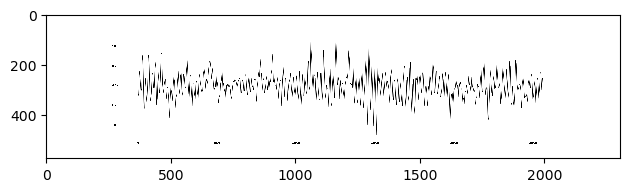

In [10]:
skimage.io.imshow(Xi)
Xi.shape

In [11]:
Xi_.show()

In [12]:
preds = rf_classifier.predict(Xi_flat)
probs = rf_classifier.predict_proba(Xi_flat)
print(preds)
print(probs)

[-1]
[[0.67 0.33]]


In [13]:
superpixels = skimage.segmentation.quickshift(Xi, kernel_size=20,max_dist=500, ratio=0.01)
num_superpixels = np.unique(superpixels).shape[0]
num_superpixels

36

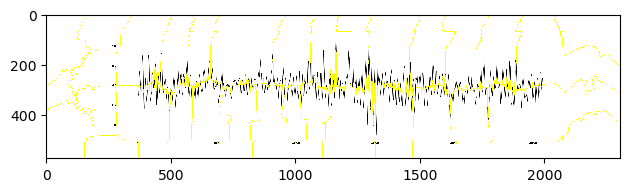

In [14]:
skimage.io.imshow(skimage.segmentation.mark_boundaries(Xi, superpixels))

In [15]:
num_perturb = 150
perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))
perturbations[0]

array([1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1])

/Users/yohanabeysinghe/miniconda3/envs/torch/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


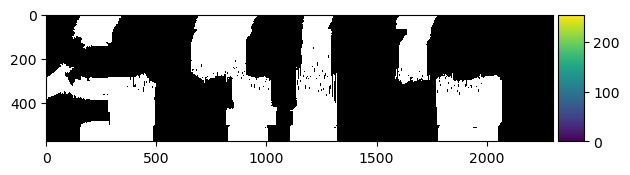

In [16]:
def perturb_image(img,perturbation,segments):
  active_pixels = np.where(perturbation == 1)[0]
  mask = np.zeros(segments.shape)
  for active in active_pixels:
      mask[segments == active] = 1 
  perturbed_image = copy.deepcopy(img)
  perturbed_image = perturbed_image*mask[:,:,np.newaxis]
  return perturbed_image


skimage.io.imshow(perturb_image(Xi,perturbations[0],superpixels))

In [17]:
perturb_image(Xi,perturbations[0],superpixels)

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]])

In [18]:
perturbed_img = perturb_image(Xi,perturbations[0],superpixels)
rf_classifier.predict(perturbed_img.flatten().reshape(1, -1))

array([-1])

In [19]:
predictions = []
for pert in perturbations:
  perturbed_img = perturb_image(Xi,pert,superpixels)
  pred = rf_classifier.predict(perturbed_img.flatten().reshape(1, -1))
  probs = rf_classifier.predict_proba(Xi_flat)
  print
  #print(pred, type(pred))
  #print(probs, type(probs))
  #pred.append(probs)
  predictions.append(probs)

predictions = np.array(predictions)
predictions.shape


(150, 1, 2)

In [20]:
predictions

array([[[0.67, 0.33]],

       [[0.67, 0.33]],

       [[0.67, 0.33]],

       [[0.67, 0.33]],

       [[0.67, 0.33]],

       [[0.67, 0.33]],

       [[0.67, 0.33]],

       [[0.67, 0.33]],

       [[0.67, 0.33]],

       [[0.67, 0.33]],

       [[0.67, 0.33]],

       [[0.67, 0.33]],

       [[0.67, 0.33]],

       [[0.67, 0.33]],

       [[0.67, 0.33]],

       [[0.67, 0.33]],

       [[0.67, 0.33]],

       [[0.67, 0.33]],

       [[0.67, 0.33]],

       [[0.67, 0.33]],

       [[0.67, 0.33]],

       [[0.67, 0.33]],

       [[0.67, 0.33]],

       [[0.67, 0.33]],

       [[0.67, 0.33]],

       [[0.67, 0.33]],

       [[0.67, 0.33]],

       [[0.67, 0.33]],

       [[0.67, 0.33]],

       [[0.67, 0.33]],

       [[0.67, 0.33]],

       [[0.67, 0.33]],

       [[0.67, 0.33]],

       [[0.67, 0.33]],

       [[0.67, 0.33]],

       [[0.67, 0.33]],

       [[0.67, 0.33]],

       [[0.67, 0.33]],

       [[0.67, 0.33]],

       [[0.67, 0.33]],

       [[0.67, 0.33]],

       [[0.67, 0

In [22]:
original_image = np.ones(num_superpixels)[np.newaxis,:] #Perturbation with all superpixels enabled 
print(original_image)
distances = sklearn.metrics.pairwise_distances(perturbations,original_image, metric='cosine').ravel()
distances.shape

(150,)

In [23]:
distances

array([0.25464401, 0.35450278, 0.39907479, 0.37639044, 0.25464401,
       0.37639044, 0.35450278, 0.27351684, 0.29289322, 0.20069475,
       0.33333333, 0.31281573, 0.37639044, 0.23623738, 0.25464401,
       0.35450278, 0.4472292 , 0.31281573, 0.29289322, 0.39907479,
       0.35450278, 0.29289322, 0.4472292 , 0.18350342, 0.25464401,
       0.33333333, 0.31281573, 0.27351684, 0.31281573, 0.29289322,
       0.31281573, 0.27351684, 0.31281573, 0.29289322, 0.27351684,
       0.18350342, 0.29289322, 0.27351684, 0.29289322, 0.31281573,
       0.25464401, 0.27351684, 0.35450278, 0.35450278, 0.25464401,
       0.35450278, 0.33333333, 0.25464401, 0.29289322, 0.33333333,
       0.35450278, 0.23623738, 0.33333333, 0.25464401, 0.39907479,
       0.37639044, 0.39907479, 0.27351684, 0.33333333, 0.25464401,
       0.20069475, 0.27351684, 0.25464401, 0.39907479, 0.37639044,
       0.29289322, 0.31281573, 0.35450278, 0.33333333, 0.23623738,
       0.35450278, 0.37639044, 0.27351684, 0.29289322, 0.42264

In [24]:
kernel_width = 1
weights = np.sqrt(np.exp(-(distances**2)/kernel_width**2)) #Kernel function
weights.shape

(150,)

In [25]:
perturbations[0].size

36

In [26]:
predictions.shape

(150, 1, 2)

In [2]:
class_to_explain = preds[0]
simpler_model = LinearRegression()
simpler_model.fit(X=perturbations, y=predictions[:,:,class_to_explain], sample_weight=weights)
coeff = simpler_model.coef_[0]
coeff.shape

NameError: name 'preds' is not defined

In [32]:
num_top_features = 4
top_features = np.argsort(coeff)[-num_top_features:] 
top_features

array([14, 15, 34, 35])

In [33]:
mask = np.zeros(num_superpixels) 
mask[top_features]= True #Activate top superpixels
out = perturb_image(Xi,mask,superpixels)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(576, 2304, 3)


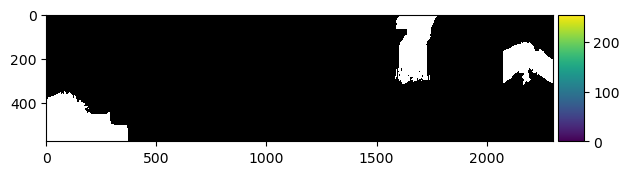

In [35]:
skimage.io.imshow(out)
print(out.shape)

(576, 2304, 3)


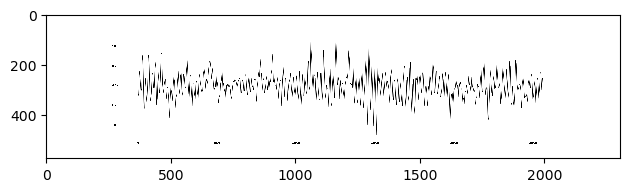

In [69]:
skimage.io.imshow(Xi)
print(Xi.shape)

In [78]:
img1 = Image.fromarray(out.astype('uint8'))
img2 = Image.fromarray(Xi.astype('uint8'))

In [81]:
img1.save("img1.png")
img2.save("img2.png")